In [2]:
import glob
import pandas
from skimage import io
import pandas as pd
import numpy as np
import skimage
import matplotlib.pyplot as plt
import cv2
from PIL import Image
from math import log10, sqrt
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing import image


Dataframe from image path

In [19]:
path = '../reference images/noise/'
images = list(glob.glob(path + '/*JPG'))
df_noise = pd.DataFrame(images,  columns=['image_path'])
df_noise['num'] = df_noise.image_path.apply(lambda x : int(x.split('.')[-2].split('_')[-1]))
df_noise.sort_values('num', inplace = True)
df_noise.reset_index(drop=True, inplace = True)
df_noise

,image_path,num
0,../reference images/noise\noisy_image_7.jpg,7
1,../reference images/noise\noisy_image_15.jpg,15
2,../reference images/noise\noisy_image_56.jpg,56
3,../reference images/noise\noisy_image_165.jpg,165
4,../reference images/noise\noisy_image_244.jpg,244


In [20]:
path = '../reference images/Jpeg Compress & noise/'
images = list(glob.glob(path + '/*JPG'))
df_Jp = pd.DataFrame(images,  columns=['image_path'])
df_Jp['num'] = df_Jp.image_path.apply(lambda x : int(x.split('.')[-2].split('_')[-1]))
df_Jp.sort_values('num', inplace = True)
df_Jp.reset_index(drop=True, inplace = True)
df_Jp

,image_path,num
0,../reference images/Jpeg Compress & noise\comp...,7
1,../reference images/Jpeg Compress & noise\comp...,15
2,../reference images/Jpeg Compress & noise\comp...,56
3,../reference images/Jpeg Compress & noise\comp...,165
4,../reference images/Jpeg Compress & noise\comp...,244


# Denoise Only

# Denoise + Jpeg Compression 

In [27]:
model = tf.keras.models.load_model('./model/dataweights78.hdf5')


In [23]:


def PSNR(original, compressed):
    mse = np.mean((original - compressed) ** 2)
    if(mse == 0): # MSE is zero means no noise is present in the signal .
                  # Therefore PSNR have no importance.
        return 100
    max_pixel = 255.0
    psnr = 20 * log10(max_pixel / sqrt(mse))
    return psnr
  

def model_compare_image_resize(org_path, new_path, model, i_size = (256,256)):
    
    original = cv2.imread(org_path)
    compressed_org = cv2.imread(new_path, 1).astype(np.float32)
    compressed = cv2.resize(compressed_org, i_size, interpolation= cv2.INTER_AREA)
    compressed /= 255.0
    compressed = compressed.reshape([1] + list(compressed.shape))
    decoded_img = model.predict(compressed)[0]
    decoded_img *= 255.0
    decoded_imgs = cv2.resize(decoded_img, (original.shape[1], original.shape[0]), interpolation= cv2.INTER_AREA)
    decoded_imgs = decoded_imgs.astype(int)
    plt.imshow(decoded_imgs)
    plt.show()

    value_predict = PSNR(original, decoded_imgs)
    value_non_predict = PSNR(original, compressed_org)
    print(f"PSNR value is model predict : {value_predict} dB")
    print(f"PSNR value is w/o model : {value_non_predict} dB")

    return value_predict, value_non_predict




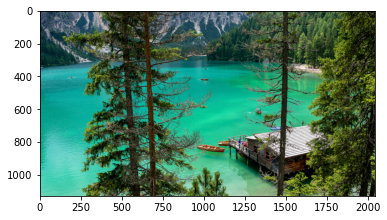

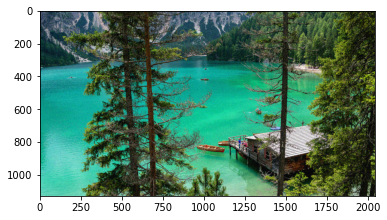

(1, 256, 256, 3)


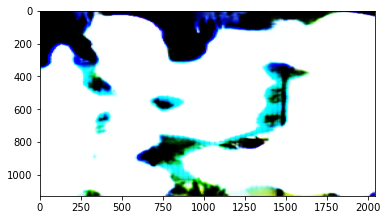

PSNR value is model predict : 3.6326641124694086 dB
PSNR value is w/o model : 21.504423468748676 dB


In [32]:
org_path = df.GT[num]
new_path = df.T2[num]

original = cv2.imread(org_path)
original = cv2.cvtColor(original, cv2.COLOR_BGR2RGB)
plt.imshow(original)
plt.show()
compressed_org = cv2.imread(new_path)
compressed_org = cv2.cvtColor(compressed_org, cv2.COLOR_BGR2RGB)
plt.imshow(compressed_org)
plt.show()
compressed_org = compressed_org.astype(np.float32)
compressed = cv2.resize(compressed_org, (256,256), interpolation= cv2.INTER_AREA)
compressed /= 255.0
compressed = compressed.reshape([1] + list(compressed.shape))
print(compressed.shape)
decoded_img = model.predict(compressed)[0]
decoded_img *= 255.0
decoded_imgs = cv2.resize(decoded_img, (original.shape[1], original.shape[0]), interpolation= cv2.INTER_AREA)
decoded_imgs = decoded_imgs.astype(int)
plt.imshow(decoded_imgs)
plt.show()

value_predict = PSNR(original, decoded_imgs)
value_non_predict = PSNR(original, compressed_org)
print(f"PSNR value is model predict : {value_predict} dB")
print(f"PSNR value is w/o model : {value_non_predict} dB")

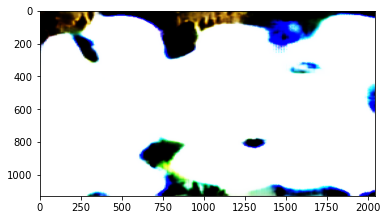

PSNR value is model predict : 3.4571076976167507 dB
PSNR value is w/o model : 100 dB


(3.4571076976167507, 100)

In [24]:
num = 9
GT_path_1 = df.GT[num]
T_path_1 = df.GT[num]

model_compare_image_resize(GT_path_1, T_path_1, model)

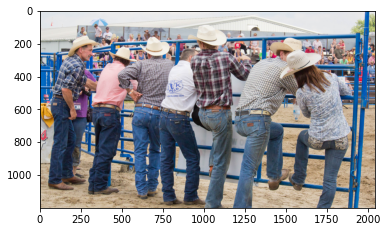

2040 1200
8 5


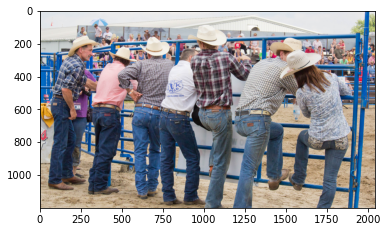

In [14]:
import math


size = 256
kernal_size = (256, 256)

img = Image.open(df.GT[0])
imgwidth, imgheight = img.size
plt.imshow(img)
plt.show()
print(imgwidth,imgheight)


print(math.ceil(imgwidth/ size),math.ceil(imgheight/size))


image_ls =[]
for row in range(math.ceil(imgwidth/ size)):
#     print('new_row')
    img_row = []
    for col in range(math.ceil(imgheight/size)):
        resize = False
        bott_x = (row+1) * size
        if bott_x > imgwidth:
            bott_x = imgwidth
            resize = True
        bott_y = (col + 1) * size
        if  bott_y > imgheight: 
            bott_y = imgheight
            resize= True
        box = (row * size, col * size, bott_x, bott_y)
        
        img_crop = img.crop(box)
        if resize:
            img_crop_new = img_crop.resize(kernal_size)
        img_row.append(img_crop)
#         plt.imshow(img_crop)
#         plt.show()
    image_ls.append(img_row)
    
img_col = []
for i in image_ls:
    img_row = [ np.array(pic) for pic in i ]
    
    img = cv2.vconcat(img_row)
    img_col.append(img)
img_complete = cv2.hconcat(img_col)
plt.imshow(img_complete)
plt.show()